# Анализ акций российских нефтяных компаний

## Оглавление

1. **Импорт необходимых библиотек**
   - Подключение библиотек для анализа данных, работы с датами и API MOEX.

2. **Вспомогательные функции**

3. **Получение данных**

4. **EDA**
   - Проверка пропущенных значений и их обработка.
   - Базовая статистика.
   - Визуализация временных рядов.
   - Тестирование временных рядов на стационарность.
   - Построение корреляционной матрицы цен акций.

5. **Обработка временных рядов**
   - Перевод временных рядов в стационарные путём вычисления процентных изменений.
   - Рассчёт основных статистик доходности акций.
   - Визуальная оценка распределения доходностей акций.
   - Корреляционная матрица доходностей акций.
   - Анализ автокорреляции (ACF) и частичной автокорреляции (PACF).

6. **Анализ волатильности**
   - Годовая скользящая волатильность в разных временных окнах.
   - Статистика по скользящей волатильности.

7. **Анализ месячных доходностей**
   - Ресэмплирование данных на месячные доходности.
   - Статистика по месячным доходностям.
   - Корреляционная матрица месячных доходностей.

8. **Динамика корреляции между акциями**
   - Анализ динамики корреляции доходностей акций в рамках года (252 дня). 

## 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import apimoex
import requests
import time
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.interpolate import CubicSpline
from scipy.signal import periodogram

## 2. Вспомогательные функции

- `parse_date` - преобразует строку даты в объект `date`


In [2]:
def parse_date(date_input: str|date) -> date:
    if isinstance(date_input, str):
        return datetime.strptime(date_input, '%Y-%m-%d').date()
    return date_input

   - `add_suffix` - добавляет суффикс к каждому элементу списка

In [3]:
def add_suffix(lst: list, suffix: str) -> list:
    return [s + suffix for s in lst]

- `get_moex_stock` - получает данные о ценах акции (тикера) с MOEX за определенный временной промежуток

Реализовано деление на несколько запросов, в случае если длина запрашиваемого диапазона слишком большая

In [4]:
def get_moex_stock(ticker: str, start: str, end: str, chunk_size: int = 1000) -> pd.DataFrame:
    all_data = []
    start = parse_date(start)
    end = parse_date(end)
    
    with requests.Session() as session:
        current_start = start
        while current_start <= end:
            current_end = min(current_start + timedelta(days=chunk_size), end)
            chunk_data = apimoex.get_market_candles(
                session=session,
                security=ticker,
                start=current_start.strftime('%Y-%m-%d'),
                end=current_end.strftime('%Y-%m-%d')
            )
            
            if chunk_data:
                df_chunk = pd.DataFrame(chunk_data)
                all_data.append(df_chunk)
            
            current_start = current_end + timedelta(days=1)
            time.sleep(1)  # Not being greedy :)
    
    if not all_data:
        return pd.DataFrame()
    
    df = pd.concat(all_data, ignore_index=True)
    df['begin'] = pd.to_datetime(df['begin']).dt.date
    df.rename({'begin': 'date', 'value': 'volume'}, axis='columns', inplace=True)
    df.set_index('date', inplace=True)
    df = df.sort_index()
    multi_index = pd.MultiIndex.from_tuples([(ticker, col) for col in df.columns], names=['Ticker', 'Indicator'])
    df.columns = multi_index
    
    return df

- `cubic_spline_interpolate` - интерполирует пропущенные значения с помощью кубических сплайнов

In [5]:
def cubic_spline_interpolate(column: pd.Series) -> pd.Series:
    valid_data = column.dropna()
    if len(valid_data) < 2:
        return column
    cs = CubicSpline(valid_data.index.astype(np.int64), valid_data.values)
    return pd.Series(cs(column.index.astype(np.int64)), index=column.index)

- `adf_test`: Проводит ADF тест на стационарность временного ряда.

In [6]:
def adf_test(series: pd.Series) -> float:
    result = adfuller(series.dropna(), autolag='AIC')
    return round(result[1], 3)

- `plot_acf_pacf` - выводит графики автокорреляции (ACF) и частичной автокорреляции (PACF)

In [7]:
def plot_acf_pacf(data: pd.DataFrame|pd.Series, lags=40):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    fig, axes = plt.subplots(len(data.columns), 2, figsize=(15, 2*len(data.columns)))
    if axes.ndim == 1:
        axes = axes.reshape(1, 2)
    for idx, ticker in enumerate(data.columns):
        series = data[ticker].dropna()
        
        # ACF
        acf_values = acf(series, nlags=lags)
        acf_values[0] = np.nan
        axes[idx, 0].stem(range(len(acf_values)), acf_values)
        axes[idx, 0].set_title(f'ACF - {ticker}')
        axes[idx, 0].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 0].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 0].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        
        # PACF
        pacf_values = pacf(series, nlags=lags)
        pacf_values[0] = np.nan
        axes[idx, 1].stem(range(len(pacf_values)), pacf_values)
        axes[idx, 1].set_title(f'PACF - {ticker}')
        axes[idx, 1].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 1].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 1].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)

    plt.tight_layout()
    plt.show()

## 3. Получение данных

Список выбранных нами тикеров компаний

In [8]:
tickers_lst = ['LKOH', 'ROSN', 'SIBN', 'SNGS', 'TATN']
start_date = '2005-01-01'
end_date = date.today().strftime('%Y-%m-%d')

Получение данных с помощью API MOEX

In [9]:
# Will take some time (~ 45s)

# df_res = pd.DataFrame()
# for ticker in tickers_lst:
#     temp_df = get_moex_stock(ticker, start_date, end_date)
#     if df_res.empty:
#         df_res = temp_df
#         continue
#     df_res = df_res.merge(temp_df, how='outer', left_index=True, right_index=True)

# df_res.to_csv('data/df_tickers.csv')

In [10]:
df_res = pd.read_csv('data/df_tickers.csv', header=[0,1], index_col=0)
df_res = df_res.set_index(pd.to_datetime(df_res.index))

Далее будем рассматривать только цены закрытия

In [11]:
df: pd.DataFrame = df_res.loc[:, (slice(None), 'close')]
df.columns = df.columns.droplevel('Indicator')

## 4. EDA

### Проверка пропущенных значений

Определение первой даты с полными данными - от нее и будем отталкиваться

In [12]:
first_valid_date = df.apply(lambda x: x.first_valid_index()).max()
df = df.loc[first_valid_date:]

first_valid_date.strftime(f'%d.%m.%Y')

'19.07.2006'

Смотрим на пропуски

In [13]:
df.isna().sum()

Ticker
LKOH    0
ROSN    0
SIBN    2
SNGS    0
TATN    2
dtype: int64

In [14]:
# Восполним недостающие временные метки
dates = pd.date_range(start=df.index[0], end=df.index[-1])
df_plot = df.reindex(dates)

# Методологически при работе с финансовыми данными лучше использовать только реальные данные
# поэтому лучше просто удалить пропуски
# Потом можно будет оценить, какой вариант лучше
df = df.dropna()

### Базовая статистика

In [15]:
df.describe().round(2)

Ticker,LKOH,ROSN,SIBN,SNGS,TATN
count,4600.00,4600.00,4600.00,4600.00,4600.00
mean,3402.24,319.33,260.91,29.35,351.20
std,1845.61,123.59,181.72,5.56,213.88
min,740.22,82.41,40.15,8.70,27.50
25%,1922.00,224.20,135.98,26.07,158.05
50%,2572.50,266.20,157.60,28.59,313.00
75%,4917.50,401.50,365.00,32.77,516.42
max,8152.00,655.25,934.25,54.17,837.00


**Вывод:**

Наблюдается большой разброс в абсолютных ценах акций: от минимума в 8.7 рублей (`SNGS`) до максимума в 8152 рубля (`LKOH`).

### Визуализация временных рядов

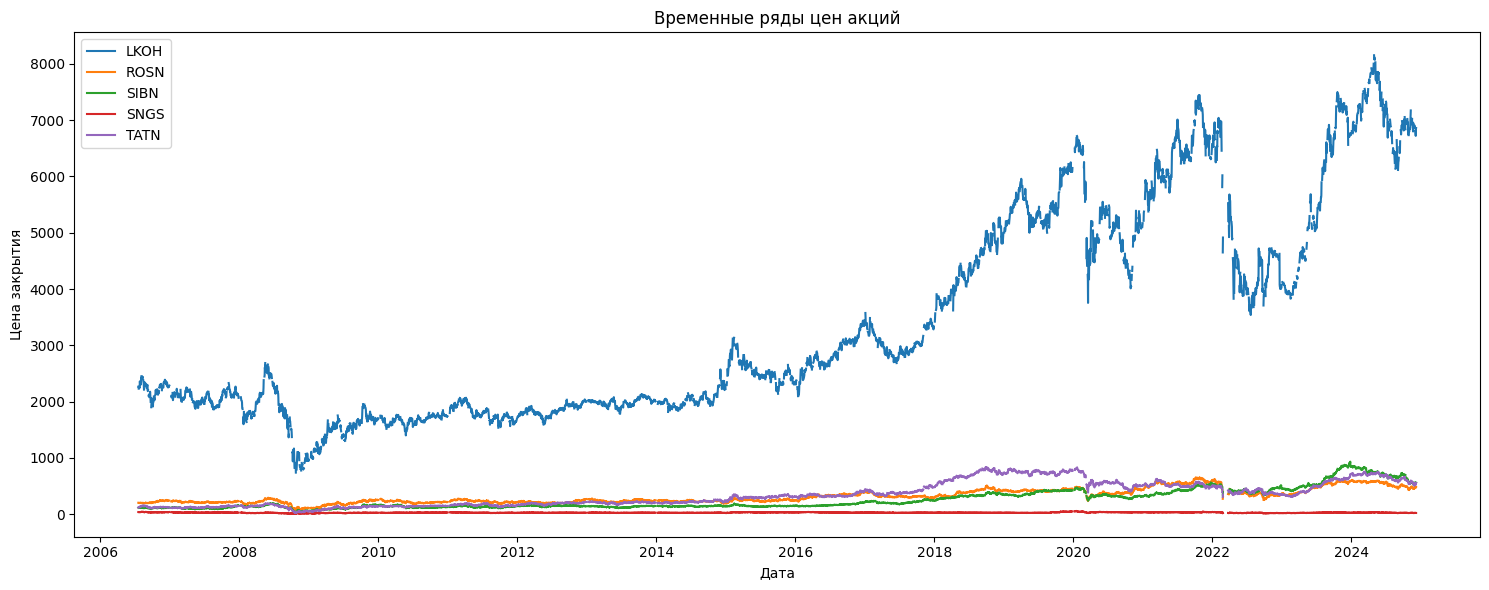

In [16]:
plt.figure(figsize=(15, 6))
for column in tickers_lst:
    plt.plot(df_plot.index, df_plot[column], label=column)
plt.title("Временные ряды цен акций")
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.legend()
plt.tight_layout()
# Приостановка торгов в 2022 году
# plt.xlim((pd.to_datetime('2022-01-01').date(), pd.to_datetime('2022-04-01').date()))
plt.show()

Посмотрим на нормализованные цены (индекс цен, где базовым является первое значение)
- Так будет лучше видна динамика акций

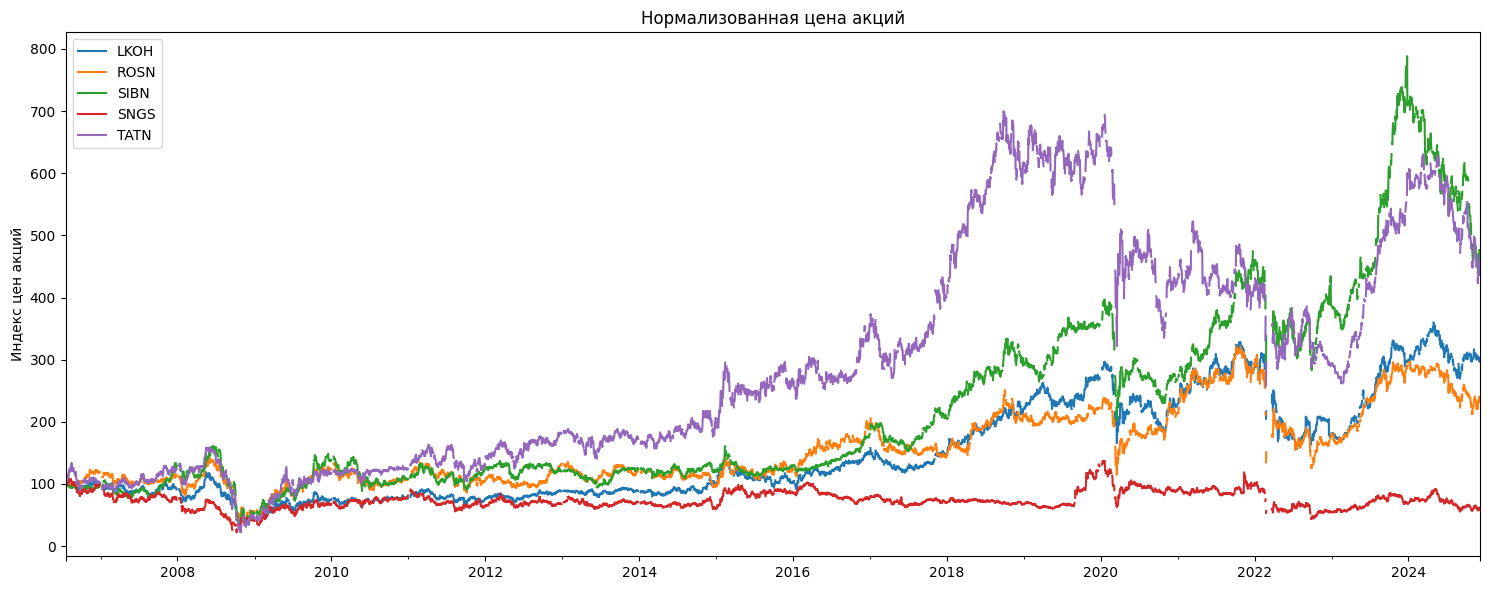

In [17]:
normalized = df_plot / df_plot.iloc[0] * 100
normalized.plot(figsize=(15, 6))
plt.title('Нормализованная цена акций')
plt.ylabel('Индекс цен акций')
plt.legend()
plt.tight_layout()
plt.show()

**Вывод:**

Все акции демонстрируют схожие паттерны движения, что указывает на сильную взаимосвязь между ними.

### Тестирование временных рядов на стационарность

Очевидно, что ряды нестационарные

In [18]:
df[tickers_lst].apply(adf_test)

Ticker
LKOH    0.818
ROSN    0.474
SIBN    0.806
SNGS    0.000
TATN    0.673
dtype: float64

Результаты ADF-теста это подтверждают

### Построение корреляционной матрицы цен акций

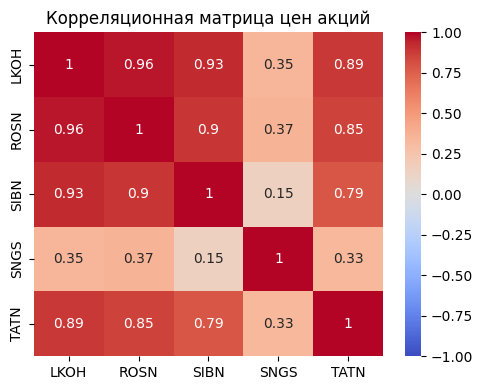

In [19]:
plt.figure(figsize=(5, 4))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица цен акций")
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Вывод:**

- Корреляционная матрица цен показывает высокую положительную корреляцию между акциями `LKOH`, `ROSN`, `SIBN`, `TATN` ($>0.7$), что типично для компаний одного сектора
- `SNGS` показывает меньшую корреляцию с остальными акциями ($<0.4$)

## 5. Обработка временных рядов

### Перевод временных рядов в стационарные

Перейдем к процентным изменениям в ценах акций
- Это позволит сразу прийти к стационарным рядам

- Эквивалентно взятию разности логарифмов

In [20]:
df_pct = df.pct_change()
df_pct.apply(adf_test)

Ticker
LKOH    0.0
ROSN    0.0
SIBN    0.0
SNGS    0.0
TATN    0.0
dtype: float64

### Рассчёт основных статистик доходности акций

In [21]:
pd.DataFrame({
    'Mean Return (%)': (df_pct.mean() * 100).round(2),
    'Volatility (%)': (df_pct.std() * 100).round(2),
    'Skewness': df_pct.skew().round(2),
    'Kurtosis': df_pct.kurtosis().round(2)
})

,Mean Return (%),Volatility (%),Skewness,Kurtosis
Ticker,,,,
LKOH,0.05,2.20,0.14,18.79
ROSN,0.05,2.41,1.06,54.93
SIBN,0.06,2.10,-0.47,17.55
SNGS,0.02,2.53,1.86,42.12
TATN,0.07,2.66,0.89,25.37


**Вывод:**

- Средняя дневная доходность всех акций положительная и находится в диапазоне $0.02-0.07\%$
- Волатильность (стандартное отклонение) находится в диапазоне $2.10-2.66\%$
- Наблюдается значительная асимметрия распределения доходностей (skewness) и высокий эксцесс (kurtosis)
    - Это означает, что распределения имеют более "острые пики" и более толстые хвосты по сравнению с нормальным распределением
    - Значит, экстремальные движения цен (как положительные, так и отрицательные) происходят чаще, чем можно было бы ожидать при нормальном распределении

### Визуальная оценка распределения доходностей акций

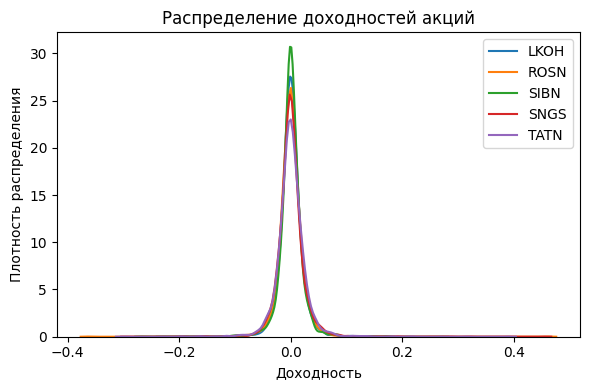

In [22]:
plt.figure(figsize=(6, 4))

for ticker in df_pct.columns:
    sns.kdeplot(data=df_pct[ticker].dropna(), label=ticker, common_norm=False)

plt.xlabel('Доходность')
plt.ylabel('Плотность распределения')
plt.title('Распределение доходностей акций')
plt.legend()
plt.tight_layout()
plt.show()

### Корреляционная матрица доходностей акций

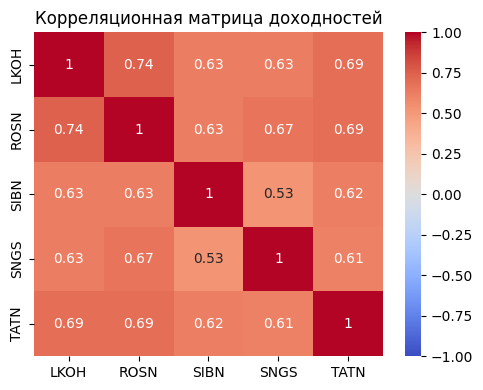

In [23]:
plt.figure(figsize=(5, 4))
correlation_matrix = df_pct.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица доходностей")
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Вывод:**

- Доходности акций также демонстрируют значимую корреляцию

### Анализ автокорреляции (ACF) и частичной автокорреляции (PACF)

Графики ACF и PACF построены без нулевого лага (равного 1) для улучшения читаемости

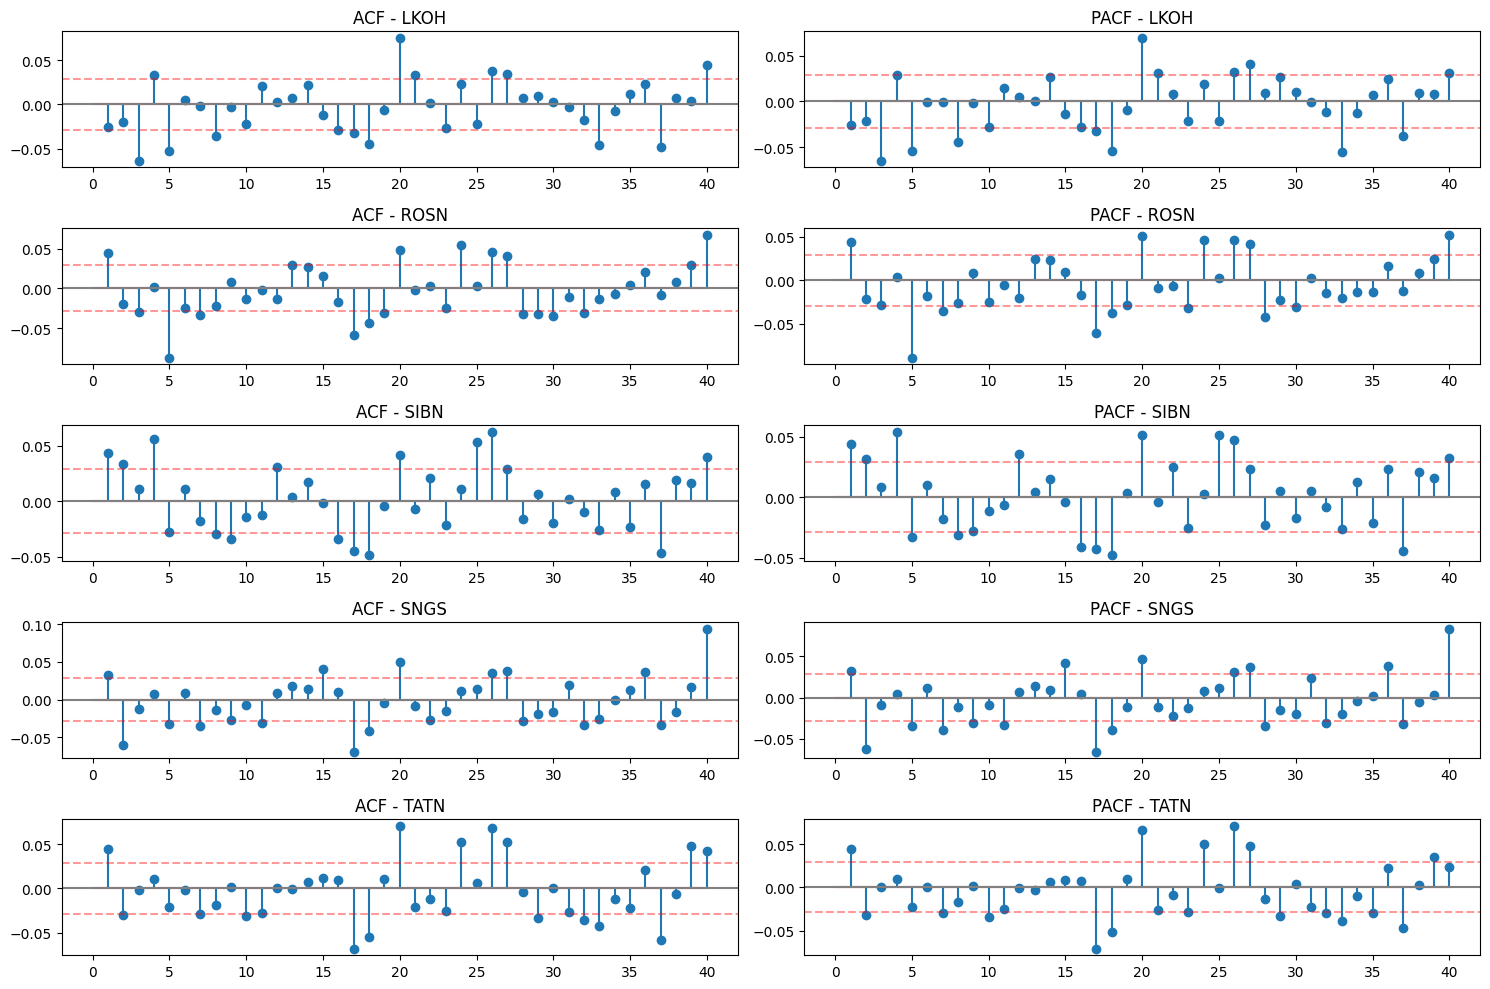

In [24]:
plot_acf_pacf(df_pct)

**Вывод:**

- В большинстве графиков ACF и PACF наблюдается наличие значимых коэффициентов на начальных лагах, особенно на лаге 1, что может указывать на автокорреляцию в доходности акций.

- На большинстве графиков ACF значения колеблются вокруг нуля, иногда выбиваясь из доверительных интервалах, но в целом явного указания на сезонность или тренд нет

- PACF также демонстрирует значимый первый лаг, однако дальнейшие значения больше напоминают белый шум

## 6. Анализ волатильности

### Годовая скользящая волатильность в разных временных окнах

Выбранные ременные окна (`vol_window`): 30 дней (месяц) и 252 дня (год торгов). Волатильность выражена в процентах в годовом выражении.

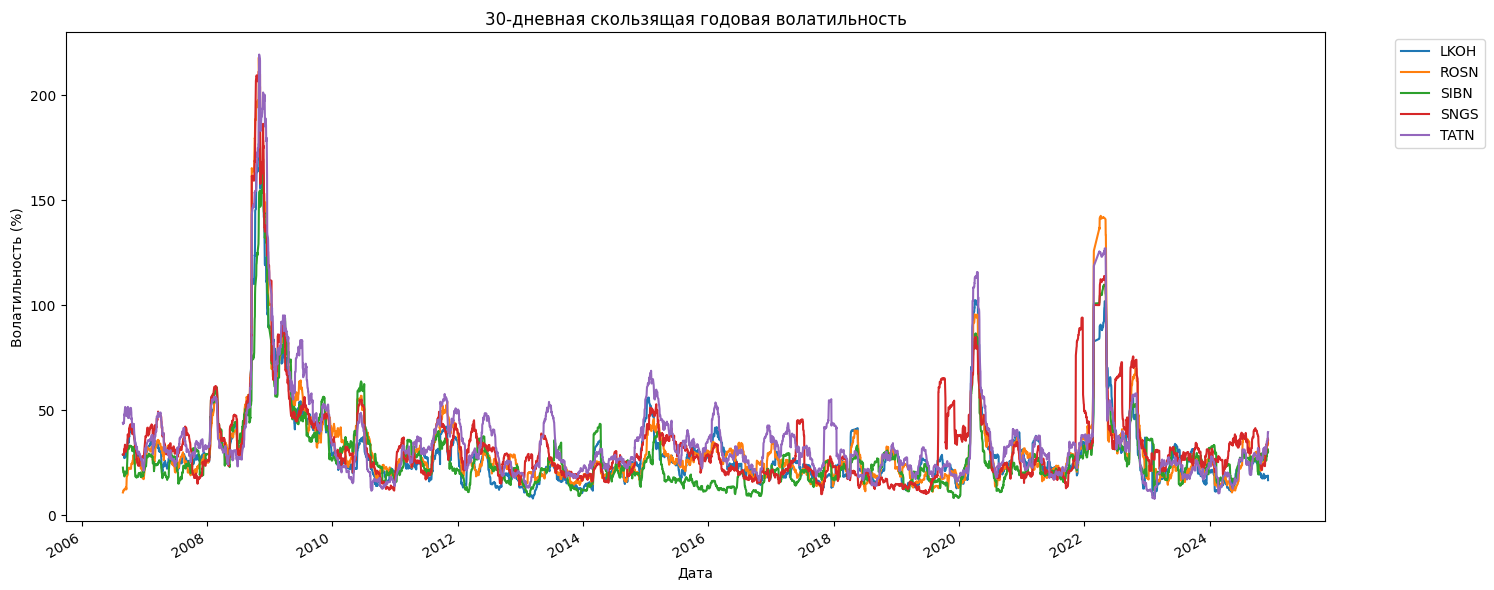

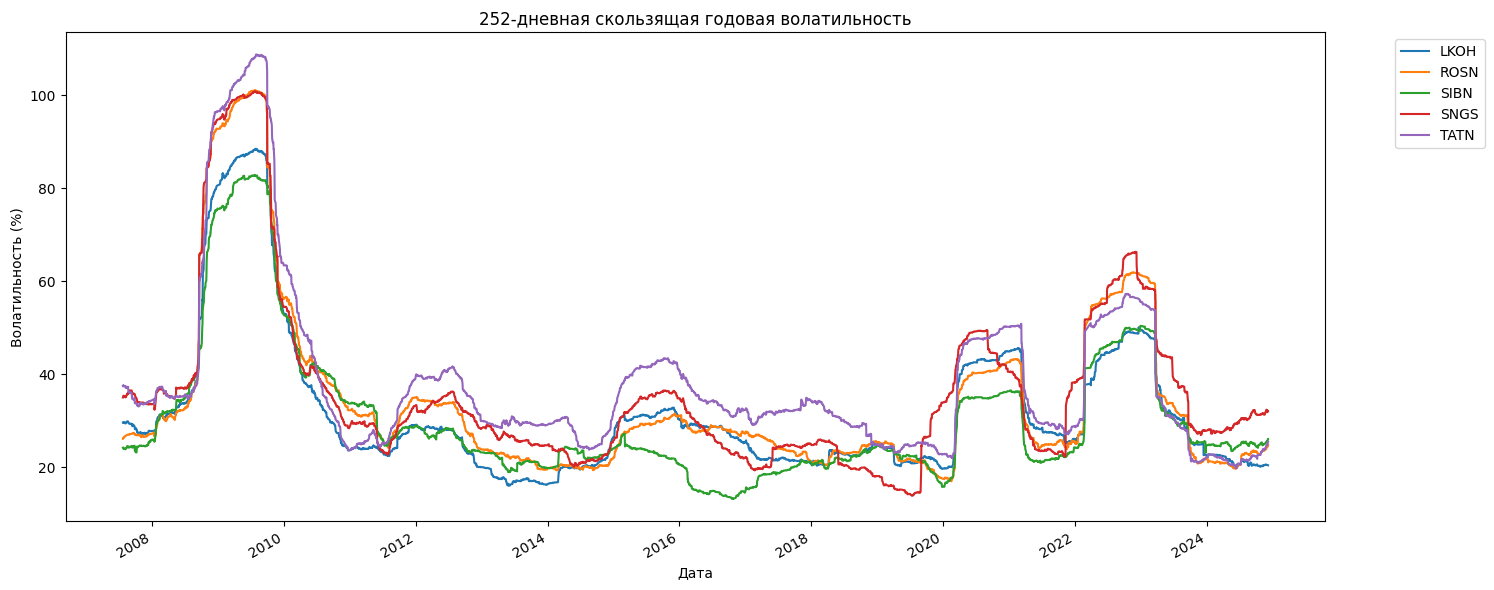

In [25]:
vol_window = 30
rolling_vol = df_pct.rolling(window=vol_window).std() * np.sqrt(252) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневная скользящая годовая волатильность')
plt.xlabel('Дата')
plt.ylabel('Волатильность (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

vol_window = 252
rolling_vol = df_pct.rolling(window=vol_window).std() * np.sqrt(252) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневная скользящая годовая волатильность')
plt.xlabel('Дата')
plt.ylabel('Волатильность (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Вывод:**

- Наблюдаются четкие периоды повышенной волатильности, совпадающие с кризисными периодами (2009, 2020, 2022)


### Статистика по скользящей волатильности

In [26]:
rolling_vol.describe().round(2)

Ticker,LKOH,ROSN,SIBN,SNGS,TATN
count,4348.00,4348.00,4348.00,4348.00,4348.00
mean,31.65,34.11,30.24,36.05,38.39
std,15.67,18.57,15.03,18.50,18.48
min,15.98,16.94,13.17,13.82,19.71
25%,21.84,23.07,21.69,24.74,28.60
50%,27.28,27.59,24.58,31.21,32.43
75%,32.83,35.26,34.49,38.46,41.42
max,88.54,101.14,82.90,100.90,108.81


**Вывод:**

- Средняя годовая волатильность варьируется от $30.27\%$ (`SIBN`) до $38.47\%$ (`TATN`)
- Максимальные значения волатильности достигали более $100\%$ в кризисные периоды

## 7. Анализ месячных доходностей

### Ресэмплирование данных на месячные доходности.

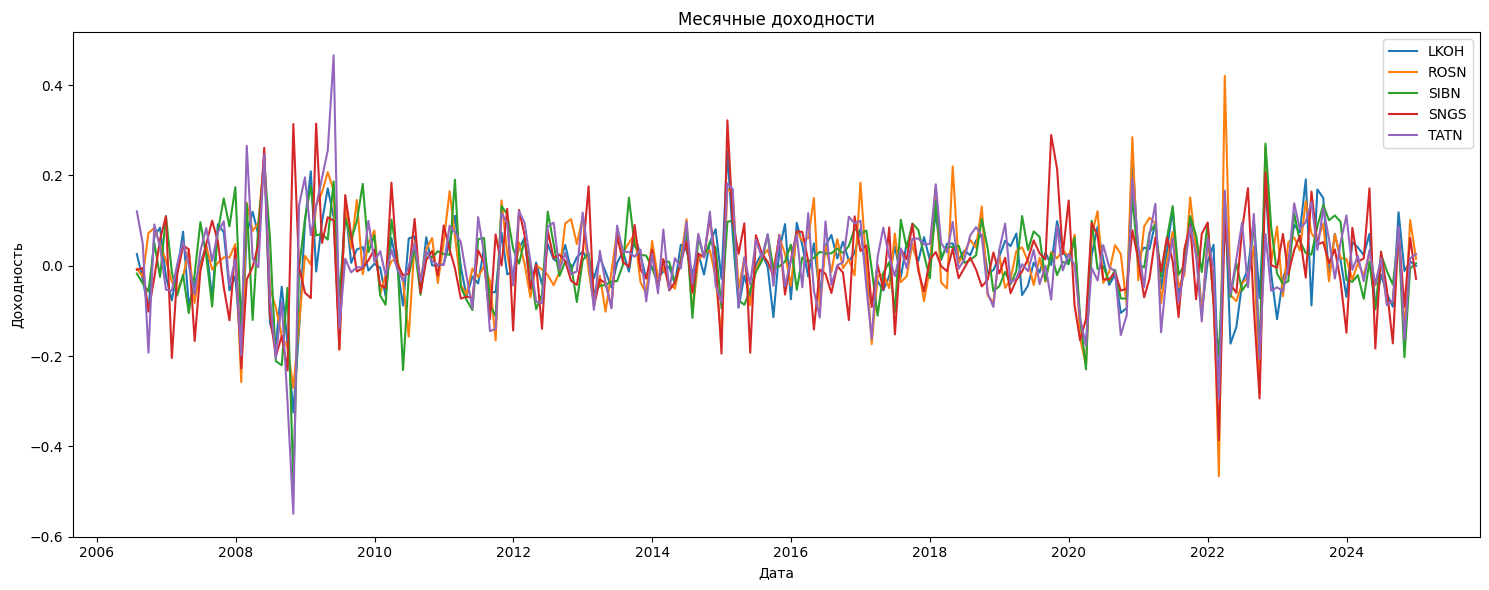

In [27]:
monthly_returns = df_pct.resample('ME').apply(lambda x: (1 + x).prod() - 1)

plt.figure(figsize=(15, 6))
for column in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[column], label=column)
plt.title("Месячные доходности")
plt.xlabel("Дата")
plt.ylabel("Доходность")
plt.legend()
plt.tight_layout()
plt.show()

### Статистика по месячным доходностям

In [28]:
monthly_returns.describe().multiply(100).round(2)

Ticker,LKOH,ROSN,SIBN,SNGS,TATN
count,22200.00,22200.00,22200.00,22200.00,22200.00
mean,0.84,0.88,1.12,0.25,1.25
std,8.13,9.75,8.83,9.82,10.11
min,-32.50,-46.62,-48.13,-38.63,-54.96
25%,-2.89,-3.70,-3.55,-4.68,-4.15
50%,0.95,1.10,1.26,0.49,1.61
75%,5.33,5.72,6.73,5.40,7.00
max,25.39,42.07,27.07,32.23,46.64


**Вывод:**

- Средняя месячная доходность положительная для всех акций ($0.26-1.25\%$)
- Наибольшую среднюю месячную доходность показывает `TATN` ($1.25\%$)
- Наибольшую волатильность на месячном горизонте демонстрирует также `TATN` ($10.14\%$)
- Наибольшие значения месячной доходности достигали около $-55\%$ (`TATN`) и $+47\%$ (`TATN`)

### Корреляционная матрица месячных доходностей

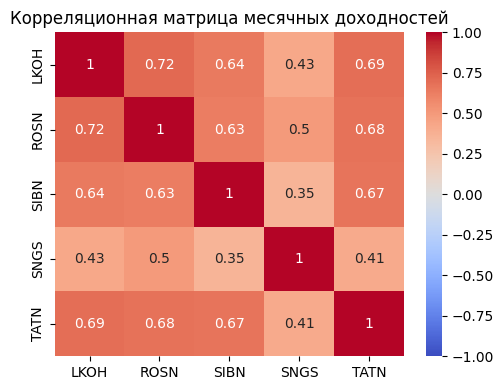

In [29]:
plt.figure(figsize=(5, 4))
correlation_matrix = monthly_returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица месячных доходностей')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Вывод:**

- Корреляция между месячными доходностями остается высокой, что говорит о сохранении взаимосвязи даже на более длительных горизонтах

## 8. Динамика корреляции между акциями

### Анализ динамики корреляции доходностей акций в рамках года (252 дня)

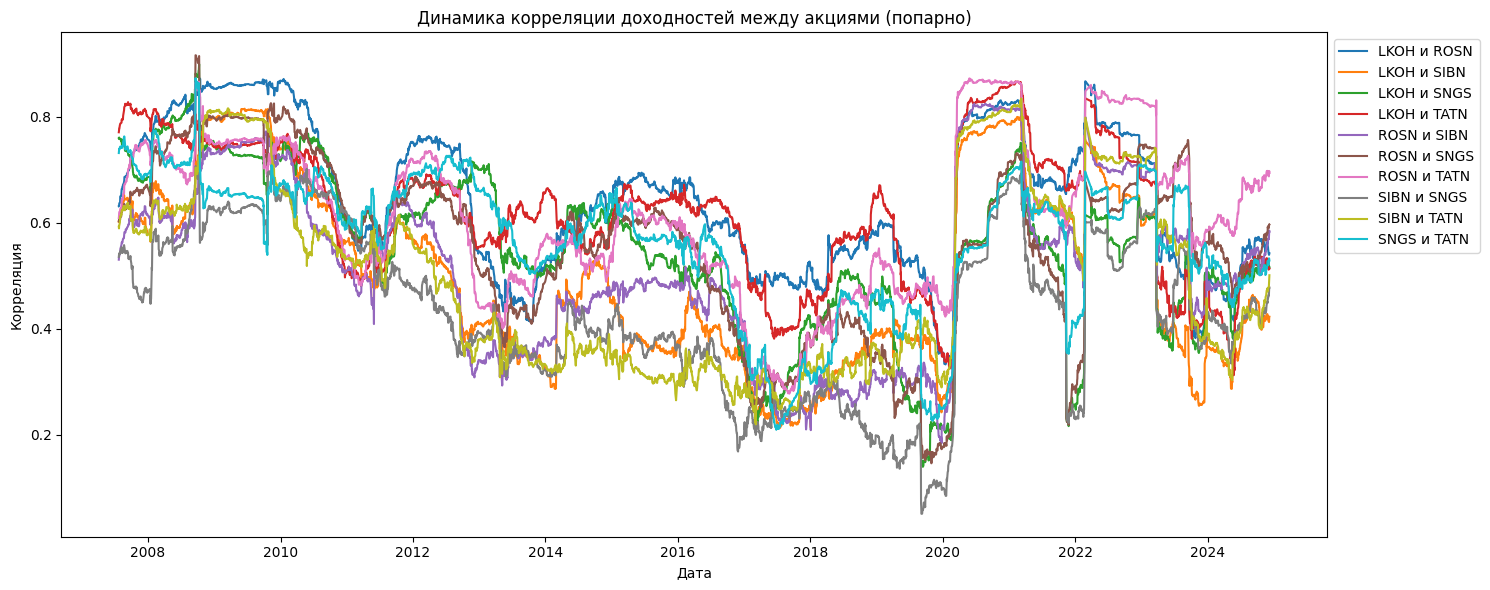

In [30]:
rolling_corr = pd.DataFrame()
window_size = 252

for ticker1 in df_pct.columns:
    for ticker2 in df_pct.columns:
        if ticker1 < ticker2:  # берем только уникальные пары
            corr = df_pct[ticker1].rolling(window=window_size).corr(df_pct[ticker2])
            rolling_corr[f'{ticker1} и {ticker2}'] = corr

plt.figure(figsize=(15, 6))
for column in rolling_corr.columns:
    plt.plot(rolling_corr.index, rolling_corr[column], label=column)
plt.title("Динамика корреляции доходностей между акциями (попарно)")
plt.xlabel("Дата")
plt.ylabel("Корреляция")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [31]:
rolling_corr.describe().round(2)

,LKOH и ROSN,LKOH и SIBN,LKOH и SNGS,LKOH и TATN,ROSN и SIBN,ROSN и SNGS,ROSN и TATN,SIBN и SNGS,SIBN и TATN,SNGS и TATN
count,4348.00,4348.00,4348.00,4348.00,4348.00,4348.00,4348.00,4348.00,4348.00,4348.00
mean,0.65,0.50,0.55,0.62,0.51,0.56,0.61,0.43,0.50,0.56
std,0.13,0.17,0.15,0.13,0.16,0.16,0.14,0.15,0.17,0.13
min,0.33,0.21,0.14,0.31,0.18,0.15,0.28,0.05,0.22,0.21
25%,0.54,0.36,0.48,0.53,0.37,0.44,0.51,0.34,0.34,0.51
50%,0.65,0.46,0.56,0.63,0.50,0.58,0.61,0.42,0.45,0.59
75%,0.76,0.63,0.67,0.73,0.62,0.67,0.72,0.55,0.63,0.66
max,0.87,0.81,0.90,0.87,0.82,0.92,0.87,0.73,0.83,0.87


**Вывод:**

- Корреляция между парами акций не является постоянной во времени

- В периоды кризисов наблюдается усиление корреляции между акциями

- Минимальные значения корреляции наблюдаются в спокойные периоды рынка

- Наиболее стабильную корреляцию ($std = 0.13$) демонстрируют пары `LKOH`-`ROSN`, `LKOH`-`TATN` и `SNGS`-`TATN`